# 物体检测案例

在本案例将学习使用深度学习技术来构建一个物体检测模型，并将其应用在华为云吉祥物“云宝”检测的任务中。物体检测技术目前广泛应用于对场景中物体的快速识别和精确定位，如：商品检测、自动驾驶等应用。

聪明可爱的“云宝”是华为云的吉祥物。这个数据集中包含大量的云宝照片，并且标注了云宝目标的位置坐标信息，如下图，标注规范同Pascal VOC目标检测数据集。
![](./img/yunbao_example.png)

其中左边是未标注的图片，右边是已标注的图片，图中的绿色长方形框就是标注框。

本案例将掌握目标检测以及yolo-v3算法的原理；掌握使用深度学习框架MXNet构建目标检测模型结构、训练模型、推理模型的方法；掌握从数据上传、代码编写、模型训练，到模型部署、推理，构建目标检测应用的全套流程 

## 步骤

### 进入ModelArts界面

这步教大家如何进入华为云ModelArts服务，ModelArts服务提供本次实验所需的环境。

第一步：点击“控制台”
![title](img/enter_modelarts_step1.png)

第二步：点击“所有服务”
![title](img/enter_modelarts_step2.png)

第三步：在“EI企业智能”大类下找到“ModelArts”，点击“ModelArts”，进入ModelArts服务主界面
![title](img/enter_modelarts_step3.png)

第四步：看到以下界面，说明成功进入了ModelArts服务主界面
![title](img/enter_modelarts_step4.png)


### 创建ModelArts notebook

此步教大家如何在ModelArts中创建一个notebook开发环境。ModelArts notebook提供网页版的Python开发环境，无需用户自己搭建Python开发环境。

第一步：点击ModelArts服务主界面中的“开发环境”
![title](img/create_notebook_step1.png)

第二步：点击“创建”按钮
![title](img/create_notebook_step2.png)


第三步：填写创建notebook所需的参数，参数设置参考下面列表。并点击下一步

| 参数 | 说明 |
|--|--|
|计费方式|按需计费|
|名称 | 开发环境实例名称，如object_detection |
|AI引擎|本案例使用MXNet引擎，Python版本对应3.6及以上|
|资源池|选择“公共资源池”即可|
|类型|GPU|
|规格|8核&#124;64GiB&#124;1*p100|
|存储配置|EVS，磁盘规格5GB|

第四步：点击“立即创建”
![title](img/create_notebook_step4.png)

第五步：点击“返回Notebook列表”
![title](img/create_notebook_step5.png)

第六步：等待Notebook的创建成功，创建成功后状态会变成“运行中”
![title](img/create_notebook_step6.png)

### 在ModelArts notebook中创建一个notebook Python开发环境

第一步：点击下图所示的“打开”按钮，进入刚刚创建的notebook
![title](img/create_notebook_dev_step1.png)

第二步：创建一个notebook Python语言开发环境。先点击“New”按钮，然后根据本案例所用的AI引擎选择对应环境。

第三步：重命名刚刚创建的notebook Python开发环境。点击“Untitle”按钮
![title](img/create_notebook_dev_step3.png)

第四步：填写名称。我们可以填写一个跟本实验相关的名称，如下图所示，然后点击“Rename”按钮
![title](img/create_notebook_dev_step4.png)

### 如何在notebook Python开发环境中写代码并执行代码

第一步：输入代码。我们打印一行字符串，如下图所示
![title](img/type_code.png)

第二步：执行代码。代码输入完成后，点击notebook界面上的“Run”按钮，就可以执行代码
![title](img/exec_code.png)

第三步：查看代码执行结果。在代码输入框下面，可以看到代码执行结果，如下图所示
![title](img/exec_code_result.png)

第四步：保存代码。代码编写完之后，我们点击下图所示的“保存”按钮，保存代码和代码执行结果
![title](img/save_code.png)

### 案例配置信息填写

案例中需要将运行结果上传至OBS中，我们需要设置以下相关参数（使用自己真实的桶名和唯一ID替换掉*号）：

* BUCKET_NAME ： 自己的OBS桶名
* UNIQUE_ID : 唯一ID，填写自己的学号或者IAM子账号名称


In [1]:
BUCKET_NAME = '*' 
UNIQUE_ID = '*' 
OBS_BASE_PATH = BUCKET_NAME + '/' + UNIQUE_ID

###  准备源代码和数据

这一步准备案例所需的源代码和数据，相关资源已经保存在OBS中，我们通过ModelArts SDK将资源下载到本地，并解压到当前目录下。解压后，当前目录包含src，data，model以及checkpoint四个目录，分别存有源代码，数据集，模型数据和模型生成记录。


In [2]:
from modelarts.session import Session
session = Session()

if sess.region_name == 'cn-north-1':
    session.download_data(bucket_path="ai-course-common-20/object_detection/object_detection.tar.gz", path="./object_detection.tar.gz")
elif sess.region_name == 'cn-north-4':
    session.download_data(bucket_path="ai-course-common-20-bj4/object_detection/object_detection.tar.gz", path="./object_detection.tar.gz")
else:
    print("请更换地区到北京一或北京四")

# 使用tar命令解压资源包
!tar xf ./object_detection.tar.gz

Successfully download file ai-course-common-20/object_detection/object_detection.tar.gz from OBS to local ./object_detection.tar.gz


**notebook Python开发环境终于准备好了，现在可以在notebook Python开发环境写代码啦**

### 导入基本工具库

执行下面方框中的这段代码，可以导入本次实验中使用的Python开发基本工具库，并下载样例中使用的数据和基础模型到notebook开发环境本地目录，同时设置全局变量。

此段打印从OBS下载数据的日志。

In [3]:
import os
os.environ['MXNET_BACKWARD_DO_MIRROR'] = '1'
import warnings
warnings.filterwarnings('ignore')
import mxnet as mx                                        # mxnet引擎包
import cv2                                                # opencv-python 软件包
import logging                                            # 日志工具 
import numpy as np                                        # python 科学计算软件包
import matplotlib.pyplot as plt                           # 绘图工具
import random                                             # python随机函数库
# 在notebook中显示matplotlib.pyplot的绘图结果
%matplotlib inline

logging.basicConfig(level=logging.INFO)                   # 日志打印级别

BATCH_SIZE = 1                                            # 批量训练的大小
NUM_CLASSES = 1                                           # 分类数
NUM_EXAMPLES = 20                                         # 总数据量
OFFSETS = [(13, 13), (26, 26), (52, 52)]                  # 模型中需要用到的偏移量
ANCHORS = [[116, 90, 156, 198, 373, 326],                 # 不同形状目标框模板
           [30, 61, 62, 45, 59, 119],
           [10, 13, 16, 30, 33, 23]]


设置文件路径

In [4]:
# 数据集本地路径
data_path = './data/'

# 基础模型darknet53的本地保存位置
base_model_prefix = './model/darknet_53'

# 训练结果本地保存位置
checkpoint_prefix = './checkpoint/yolov3_yunbao'

### 读取数据集

文件src/data/yolo_dataset.py定义了get_data_iter接口，返回基于mx.gluon.data.DataLoader的数据迭代器。此方法封装了数据增强操作包括，随机扩张、裁剪、翻转、归一化等。

此段打印数据标签预读日志。

In [5]:
from src.data.yolo_dataset import get_data_iter
train_data,_ = get_data_iter(data_path=data_path,                                        # 数据根目录
                             train_file=None,                                            # 训练数据列表，可以为空
                             hyper_train={'width': 416,                                  # 输入图片的宽
                                          'height': 416,                                 # 输入图片的高
                                          'batch_size': BATCH_SIZE,                      # 批量读取数据的
                                          'index_file': './index',                       # 标签名文件，如果不存在，则自动生成
                                          'shuffle': True,                               # 打乱数据
                                          'preprocess_threads': 0},                      # 读数据进程数，大于0时需要使用系统共享内存
                             hyper_val={'width': 416,                                    # 输入图片的宽
                                        'height': 416,                                   # 输入图片的高
                                        'batch_size': BATCH_SIZE,                        # 批量读取数据的
                                        'index_file': './index',                         # 标签名文件，如果不存在，则自动生成
                                        'preprocess_threads': 0},                        # 读数据进程数，大于0时需要使用系统共享内存
                             anchors=ANCHORS,                                            # 不同形状目标框模板
                             offsets=OFFSETS                                             # 模型中需要用到的偏移量
                            )

### 打印读取的第一张图片 

获取第一个batch的第一张图片。

此段代码打印出预处理过后的图片。

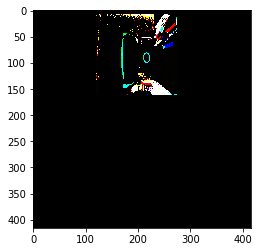

In [6]:
# 从迭代器获取数据
next_data_batch = next(iter(train_data))
img = next_data_batch.data[0][0].transpose(axes=(2,1,0))
img = img.asnumpy().astype('uint8')
# 画图，数据增强、归一化后的图片
fig = plt.figure()
plt.imshow(img)
plt.show()

### 打印读取的第一个标签

打印图像标签。

我们这样定义一个目标检测标签的格式：\[xmin, ymin, xmax, ymax, cls, difficult\]，其中(xmin, ymin)是左上角坐标，(xmax, ymax)是右下角坐标，cls是类别标签编号，difficult标识是否是难训练样本。

此段代码打印如上格式的标签信息。

In [7]:
# 打印label，[xmin， ymin， xmax, ymax, cls, difficult]
print (train_data._dataset.label_cache[11])

[[ 334.   93.  805.  690.    0.    0.]]


### 神经网络结构搭建

src/symbol/yolov3.py文件详细定义了mxnet-yolov3的网络结构，其中get_feature函数返回特征提取结果，get_yolo_output函数获得具体检测结果包括检测框的位置信息、分类信息、置信度等，get_loss定义了训练时的损失函数，pred_generator定义了推理时模型返回结果。

此段无输出。

In [8]:
from src.symbol.yolov3 import get_symbol
# get_symbol函数返回mx.sym.Symbol类型的变量
yolo_v3_net = get_symbol(num_classes=NUM_CLASSES,                             # 模型分类数
                         is_train=True)                                       # 是否用于训练任务

### 训练
#### 第一步：新建mxnet训练模块

可以将mxnet.mod.Module模块看做一个计算引擎，它包含了计算图生成和绑定、参数初始化、前向计算、后向计算、参数更新、模型保存、日志打印等相关逻辑。
初始化该模块需要传入模型结构以及计算使用的硬件环境，详见http://mxnet.incubator.apache.org/api/python/module/module.html#mxnet.module.Module 。

此段代码会打印出模型训练时需要更新的参数名。

In [9]:
# 设置gpu计算。
devs = mx.gpu(0)

model = mx.mod.Module(context=devs,                                                                           # 计算设备
                      symbol=yolo_v3_net,                                                                     # 模型结构
                      data_names=['data'],                                                                    # 模型中使用的输入数据名称
                      label_names=['gt_boxes', 'obj_t', 'centers_t', 'scales_t', 'weights_t', 'clas_t'])      # 模型中使用的输入标签名称
# 打印模型训练中参与更新的参数
print (model._param_names)

['conv_0_weight', 'bn_0_gamma', 'bn_0_beta', 'conv_1_weight', 'bn_1_gamma', 'bn_1_beta', 'conv_2_weight', 'bn_2_gamma', 'bn_2_beta', 'conv_3_weight', 'bn_3_gamma', 'bn_3_beta', 'conv_4_weight', 'bn_4_gamma', 'bn_4_beta', 'conv_5_weight', 'bn_5_gamma', 'bn_5_beta', 'conv_6_weight', 'bn_6_gamma', 'bn_6_beta', 'conv_7_weight', 'bn_7_gamma', 'bn_7_beta', 'conv_8_weight', 'bn_8_gamma', 'bn_8_beta', 'conv_9_weight', 'bn_9_gamma', 'bn_9_beta', 'conv_10_weight', 'bn_10_gamma', 'bn_10_beta', 'conv_11_weight', 'bn_11_gamma', 'bn_11_beta', 'conv_12_weight', 'bn_12_gamma', 'bn_12_beta', 'conv_13_weight', 'bn_13_gamma', 'bn_13_beta', 'conv_14_weight', 'bn_14_gamma', 'bn_14_beta', 'conv_15_weight', 'bn_15_gamma', 'bn_15_beta', 'conv_16_weight', 'bn_16_gamma', 'bn_16_beta', 'conv_17_weight', 'bn_17_gamma', 'bn_17_beta', 'conv_18_weight', 'bn_18_gamma', 'bn_18_beta', 'conv_19_weight', 'bn_19_gamma', 'bn_19_beta', 'conv_20_weight', 'bn_20_gamma', 'bn_20_beta', 'conv_21_weight', 'bn_21_gamma', 'bn_21_be

#### 第二步：优化器设置

文件src/utils/lr_schedular.py中定义了学习率的变化方式，WarmUpMultiFactorScheduler类使得学习率按如下图趋势变化：
![title](img/lr_schedular.png)



横坐标是epoch数，纵坐标是学习率。

此段代码无回显。

In [10]:
from src.utils.lr_schedular import WarmUpMultiFactorScheduler

lr_steps = '20,30'                                                                    # 学习率下降的epoch数
lr = 0.00001                                                                             # 学习率
wd = 0.00001                                                                            # 权值衰减系数
mom = 0.9                                                                              # 动量参数
warm_up_epochs = 1                                                                     # 学习率‘热身’的epoch数

# 根据BATCH_SIZE计算与epoch对应的step数
epoch_size = NUM_EXAMPLES // BATCH_SIZE
step_epochs = [float(l) for l in lr_steps.split(',')]
steps = [int(epoch_size * x) for x in step_epochs]
warmup_steps = int(epoch_size * warm_up_epochs)
# lr变化策略，带warmup的MultiFactor
lr_scheduler = WarmUpMultiFactorScheduler(step=steps,                                  # 学习率下降的步数位置
                                          factor=0.1,                                  # 学习率下降的比率
                                          base_lr=lr,                                  # 基础学习率
                                          warmup_steps=warmup_steps,                   # 学习率‘热身’提高的步数
                                          warmup_begin_lr=0.0,                         # 起始学习率
                                          warmup_mode='linear')                        # 学习率‘热身’提升的方式，这里设置为线性提升
# 将优化器参数汇总成一个python字典
optimizer_params = {'learning_rate': lr,
                    'wd': wd,
                    'lr_scheduler': lr_scheduler,
                    'rescale_grad': (1.0 / (BATCH_SIZE)),
                    'multi_precision': True,
                    'momentum': mom}

#### 第三步：初始化函数

针对网络中使用的offset、anchor参数，采用常量初始化，在训练过程中这些参数不参与更新；神经网络中的其它参数（权重、偏置等），使用Xavier算法初始化。

此段代码无回显。

In [11]:
# 将目标框扩展成所需的shape
def get_anchors(anchors):
    anchor_list = []
    for item in anchors:
        anchor = mx.nd.array(item)
        anchor = anchor.reshape(1, 1, -1, 2)
        anchor_list.append(anchor)
    return anchor_list

# 将偏移量扩展成所需的shape
def get_offsets(offsets):
    offset_list = []
    for item in offsets:
        grid_x = np.arange(item[1])
        grid_y = np.arange(item[0])
        grid_x, grid_y = np.meshgrid(grid_x, grid_y)
        offset = np.concatenate((grid_x[:, :, np.newaxis], grid_y[:, :, np.newaxis]), axis=-1)
        offset = np.expand_dims(np.expand_dims(offset, axis=0), axis=0)
        offset = mx.nd.array(offset).reshape(1, -1, 1, 2)
        offset_list.append(offset)
    return offset_list

offset_data = get_offsets(OFFSETS)
anchor_data = get_anchors(ANCHORS)
# offset、anchor参数，采用常量初始化；其它参数采用Xavier初始化
initializer = mx.init.Mixed(['offset_0_weight', 'offset_1_weight', 'offset_2_weight',
                             'anchors_0_weight', 'anchors_1_weight', 'anchors_2_weight',
                             '.*'],
                            [mx.init.Constant(offset_data[0]),
                             mx.init.Constant(offset_data[1]),
                             mx.init.Constant(offset_data[2]),
                             mx.init.Constant(anchor_data[0]),
                             mx.init.Constant(anchor_data[1]),
                             mx.init.Constant(anchor_data[2]),
                             mx.init.Xavier(factor_type="in", magnitude=2.34)])

#### 第四步：加载基础网络darknet53的参数（基于imagenet训练）

imagenet是图像识别领域最大的数据库。darknet53是一个物体检测神经网络。

此段代码打印基础网络darknet53的完整结构。

In [12]:
epoch = 0                                                                                   # 模型保存编号
sym_darknet_53, arg, aux = mx.model.load_checkpoint(base_model_prefix, epoch)               # 参数保存在arg_params，aux_params中
# 打印darknet53模型结构
mx.viz.plot_network(sym_darknet_53)

#### 第五步：设置回调函数

回调函数中定义每一个step训练完后的操作和每一个epoch训练完后的操作，其中一个step指完成一个batch size大小数据的训练，一个epoch是指完成一遍整个数据集的训练。

此段代码无回显。

In [13]:
# 设置参数同步方式
kv = mx.kvstore.create('local')

# 设置Loss打印
from src.utils.yolo_metric import YoloLoss
metrics = [YoloLoss(name='ObjLoss', index=0),
           YoloLoss(name='BoxCenterLoss', index=1),
           YoloLoss(name='BoxScaleLoss', index=2),
           YoloLoss(name='ClassLoss', index=3)]

# 回调函数
# 设置日志打印频率，通常每个step回调一次
batch_end_callback = [mx.callback.Speedometer(BATCH_SIZE, 1, auto_reset=False)]
# 设置模型保存位置、频率，同常每个epoch回调一次
epoch_end_callback = [mx.callback.do_checkpoint(checkpoint_prefix, 5)]

#### 第六步：开始训练

调用model对象的fit函数开始训练，20个epoch大概需要运行5分钟左右完成。

此段代码无输出。

In [14]:
# 把前面设置的参数放入fit函数中开始训练
model.fit(train_data=train_data,                                        # 训练数据集
          optimizer='sgd',                                              # 优化器类型
          kvstore=kv,                                                   # 设置参数同步方式
          optimizer_params=optimizer_params,                            # 优化器参数        
          batch_end_callback=batch_end_callback,                        # 每个step结束的回调函数
          epoch_end_callback=epoch_end_callback,                        # 每个epoch结束的回调函数
          initializer=initializer,                                      # 参数初始化函数
          arg_params=arg,                                               # 预加载的参数
          aux_params=aux,                                               # 预加载的参数
          eval_metric=metrics,                                          # 设置Loss打印
          num_epoch=20,                                                  # 设置遍历数据集次数
          allow_missing=True)                                           # 是否允许预加载的参数部分缺失

#### 第七步：上传模型至OBS

使用ModelArts SDK将模型上传至OBS保存，方便以后使用。

In [15]:
session.upload_data(bucket_path=OBS_BASE_PATH + "/object_detection", path= "./model")

/home/jovyan/modelarts-sdk/obs/client.py:498: DeprecationWarning: key_file, cert_file and check_hostname are deprecated, use a custom context instead.
  conn = httplib.HTTPSConnection(server, port=port, timeout=self.timeout, context=self.context, check_hostname=False)


Successfully upload file ./model to OBS xuchao8/user3/object_detection
Successfully upload file ./model to OBS xuchao8/user3/object_detection
Successfully upload file ./model to OBS xuchao8/user3/object_detection
Successfully upload file ./model to OBS xuchao8/user3/object_detection


<p style="font-family: Arial; font-size:1.4em;color:gold;">总结：该案例的model目录（OBS路径）的下存在保存的模型文件。</p>

### 推理

#### 第一步：读取图片

从obs上读取1张图片，进行归一化，并将其打包成mxnet引擎能识别的mx.io.DataBatch类型。

此段代码会打印读取的图片。

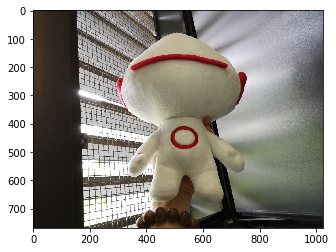

In [16]:
# 图片保存位置
file_name = os.path.join(data_path, 'train/IMG_20180919_115501.jpg')
# 图像输入的长宽
h=416
w=416
# 图像归一化需要的均值和方差
mean=(0.485, 0.456, 0.406)
std=(0.229, 0.224, 0.225)
# 加载moxing库用于直接读取保存在obs上的图片
import moxing as mox
# 以二进制形式，将图片读入内存
img = mox.file.read(file_name, binary=True)
# 保存原图，用于展示
orig_img = mx.img.imdecode(img, to_rgb=1).asnumpy().astype('uint8')
plt.imshow(orig_img)
plt.show()

# 图像预处理，归一化，resize，用于模型推理
img = mx.img.imdecode(img, 1)
img = mx.image.imresize(img, w, h, interp=2)
img = mx.nd.image.to_tensor(img)
img = mx.nd.image.normalize(img, mean=mean, std=std).expand_dims(0)

# 准备输入数据
provide_data = [mx.io.DataDesc(name='data', shape=(1, 3, h, w))]
batch_data = mx.io.DataBatch(data=[img], provide_data=provide_data)

#### 第二步：加载训练完成的模型文件

加载前面训练出的模型，模型保存在本地路径checkpoint_prefix中。

此段代码无回显。

In [17]:
load_epoch = 20                                                                               # 模型保存编号,请根据实际情况设置
_, arg_params, aux_params = mx.model.load_checkpoint(checkpoint_prefix, load_epoch)          # 参数保存在arg_params，aux_params中

#### 第三步：加载推理使用的模型结构

与训练不同，此时的模型不再包含损失函数，模型输出也被整理成\[分类结果，置信度，边框坐标\]的形式。模型参数不变。

此段打印yolov3推理时模型结构。

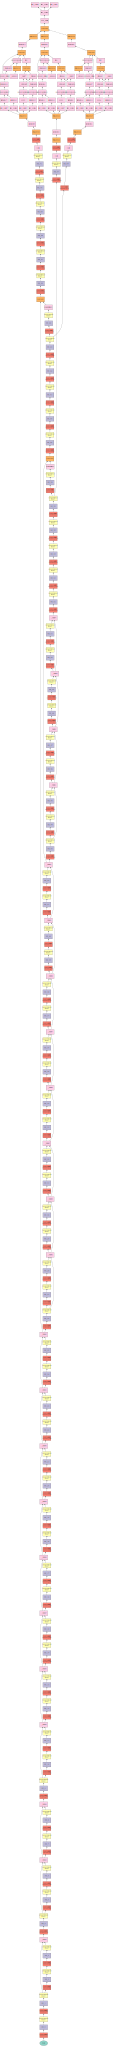

In [18]:
from src.symbol.yolov3 import get_symbol
yolo_v3_net_pre = get_symbol(num_classes=NUM_CLASSES,                  # 模型分类数
                             is_train=False)                           # 模型结构用于推理
# 打印模型结构
mx.viz.plot_network(yolo_v3_net_pre)

#### 第四步：新建mxnet推理模块

同样是mxnet.mod.Module模块，相比训练时，此时的计算逻辑去除了反向传播和参数更新。

此段代码无回显。

In [19]:
devs = mx.gpu(0)
model_pre = mx.mod.Module(
        context=mx.gpu(),                        # 使用gpu进行推理
        symbol=yolo_v3_net_pre,                   # 推理模型结构
        data_names=['data'],                      # 输入数据的名称，与前面准备输入数据时provide_data中的名称相同
        label_names=None)                         # 推理无需输入label
model_pre.bind(for_training=False,                       #绑定计算模块到底层计算引擎
           data_shapes=batch_data.provide_data,
           label_shapes=None)
model_pre.set_params(arg_params, aux_params)             # 将下载的训练完成的参数加载进计算模块

#### 第五步：执行推理计算

此段代码无回显。

In [20]:
model_pre.forward(batch_data,                                        # 输入数据
                  is_train=False)                                   # 控制引擎只进行前向计算
pred = model_pre.get_outputs()                                      # 获得推理结果
ids, scores, bboxes = [xx[0].asnumpy() for xx in pred]

#### 第六步：解析并绘制结果

会输出推理结果。根据设置的置信度，可能会输出多个矩形框。

由于训练数据量少，训练时间短，推理任务加载的模型精度较低，画出的目标框会存在不准确的现象。适当调整优化器参数，延长训练步数会提升模型精度。

此段打印带预测目标框的推理结果。

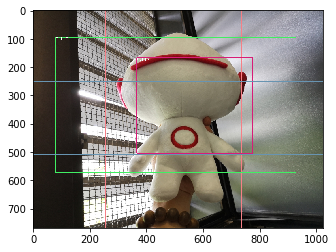

In [21]:
THRESH = 0.05                                              # 置信度阈值
im_array = orig_img.copy()
color_white = (255, 255, 255)
x_scale = im_array.shape[1] / 416.0
y_scale = im_array.shape[0] / 416.0
for idx in range(ids.shape[0]):
    if ids[idx][0] < 0 or scores[idx][0] < THRESH:
        continue
    # 按原图比例缩放目标框
    bbox = [int(bboxes[idx][0] * x_scale),
            int(bboxes[idx][1] * y_scale),
            int(bboxes[idx][2] * x_scale),
            int(bboxes[idx][3] * y_scale)]
    color = (random.randint(0, 256), random.randint(0, 256), random.randint(0, 256))
    # 在图像上画框
    cv2.rectangle(im_array, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color=color, thickness=2)
    # 把置信度写在图像上
    cv2.putText(im_array, '%.3f' % (scores[idx][0]), (bbox[0], bbox[1] + 10),
                color=color_white, fontFace=cv2.FONT_HERSHEY_COMPLEX, fontScale=0.5)
plt.imshow(im_array)
plt.show()

### 总结

本实验展示了构建目标检测应用的全流程，以及yolo_v3算法的原理，并通过云宝检测应用加深了对目标检测理论的理解。